## Colorizer3000

Grayscale image as the average of the three color channels. -> CIFAR 10 dataset

In [8]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchsummary import summary
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Lambda
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

device = "cuda" if torch.cuda.is_available() else "cpu"

#### What next?

PLAN:
1. convert training data into grayscale
2. convert testing data as well
3. convert data into tensor form for easy input into NN
4. train
5. evaluate
6. test on unseen data from the real world

IMPROVEMENTS:
* increase NN
* longer training

### loading data

In [9]:
import ssl
# Disable SSL verification
ssl._create_default_https_context = ssl._create_default_https_context = ssl._create_unverified_context

train_data = CIFAR10(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./datasets', train=False, download=False, transform=transforms.ToTensor())


Files already downloaded and verified


In [10]:
def rgb_to_gray(rgb_image):
    r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2] # separate into individual colors
    gray_image = (r+g+b)/3 # take the mean - luminosity method
    return gray_image.astype(np.uint8) # converting to 1 channel

# Actual Grayscale
# def rgb_to_gray(rgb_image):
#     r, g, b = rgb_image[:, :, 0], rgb_image[:, :, 1], rgb_image[:, :, 2] # separate into individual colors
#     #gray_image = 0.2989 * r + 0.5870 * g + 0.1140 * b # take the mean - luminosity method
#     #gray_image = 0.2125 * r + 0.7154 * g + 0.0721 * b
#     return gray_image.astype(np.uint8) # converting to 1 channel

In [11]:
# get grayscale and color data
data_from_training = train_data.data
data_from_testing = test_data.data

gray_data = np.array([rgb_to_gray(rgb_image) for rgb_image in data_from_training])
gray_data_testing = np.array([rgb_to_gray(rgb_image) for rgb_image in data_from_testing])

# convert to Tensors
gray_tensor = torch.tensor(gray_data, dtype=torch.float32).unsqueeze(1)
color_tensor = torch.tensor(data_from_training, dtype=torch.float32) / 255.0

# Creating grayscale and color datasets
gray_dataset = TensorDataset(gray_tensor, color_tensor)

# creating dataloaders
gray_dataloader = DataLoader(gray_dataset, batch_size=64, shuffle=True, pin_memory=True)
color_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)

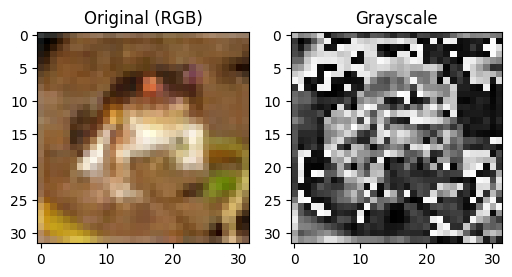

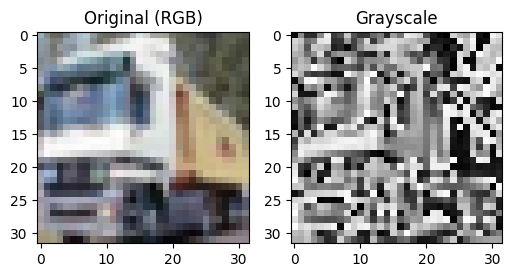

In [12]:
index_to_visualize = 2

for i in range(index_to_visualize):
  original_image = Image.fromarray(data_from_training[i])
  gray_image = Image.fromarray(gray_data[i], 'L')

  plt.figure(figsize=(6, 4))
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("Original (RGB)")

  plt.subplot(1, 2, 2)
  plt.imshow(gray_image, cmap ="gray")
  plt.title("Grayscale")

plt.show()

In [13]:
# CNN for colorizing
class Colorizer3000(nn.Module):
    def __init__(self):
        super(Colorizer3000, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # 1 channel goes in
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # extracting features
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # extracting features
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # extracting features
            nn.ReLU()
        )
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1), # 3 channels come out
            nn.Sigmoid()  # Sigmoid --> values are in [0, 1]
        )

    def forward(self, x): # Forward prop
        x = self.conv_layers(x)
        x = self.deconv_layers(x)
        return x

In [14]:
model = Colorizer3000()
model.to(device) # move to device

# LOSS FUNCTION and OPTIMIZER - difference between OG and NEW
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # learning rate

# TRAINING loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0 # accumulates losses for display
    for gray_images, color_images in gray_dataloader: # run through dataloader with both gray and color images
        gray_images = gray_images.to(device) # put to device
        color_images = color_images.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_color = model(gray_images) # colorisation process

        # resizing output to match the size of color_images
        predicted_color_resized = F.interpolate(predicted_color, size=(32, 32), mode='bilinear', align_corners=False)
        color_images = color_images.permute(0, 3, 1, 2)  # (batch_size, 32, 32, 3) to (batch_size, 3, 32, 32)

        # Calculate the loss - difference between predicted-color / original image
        loss = criterion(predicted_color_resized, color_images)

        # Backward pass and optimization
        loss.backward()
        optimizer.step() # update params

        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(gray_dataloader)}")

print("Training finished!")

# Saving the model
torch.save(model.state_dict(), "colorizer_model.pth")

In [ ]:
# Load the trained model
model = Colorizer3000()
model.load_state_dict(torch.load("colorizer_model.pth"))
model.to(device)
model.eval() # eval mode

# Colorize 10 grayscale images and compare with original colored images
num_samples_to_visualize = 10

plt.figure(figsize=(6, 3 * num_samples_to_visualize))

for i in range(num_samples_to_visualize):
    # Convert individ. grayscale image to tensor and move to device
    gray_image = gray_data_testing[i]
    print("number of gray instances - " + str(len(gray_data_testing)))
    print("number of original instances - " + str(len(data_from_testing)))
    gray_image_tensor = torch.tensor(gray_image, dtype=torch.float32).unsqueeze(0).to(device)

    # Colorize grayscale image
    with torch.no_grad():
        colorized_image_tensor = model(gray_image_tensor)

    #### Convert the tensor back to numpy array and normalize to [0, 1]
    colorized_image = colorized_image_tensor.squeeze(0).cpu().numpy()
    colorized_image = (colorized_image - colorized_image.min()) / (colorized_image.max() - colorized_image.min())

    original_image = data_from_testing[i] / 255.0  # Scale to [0, 1] -> B or W -> normalisation

    # Plot the original
    plt.subplot(num_samples_to_visualize, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title("Original (RGB)")
    plt.axis('off')

    # Plot the colorized image
    plt.subplot(num_samples_to_visualize, 2, 2 * i + 2)
    plt.imshow(colorized_image.transpose(1, 2, 0))  # Transpose the tensor to (32, 32, 3)
    plt.title("New Colorized")
    plt.axis('off')

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'colorizer_model.pth'

In [ ]:
# load modeling
model = Colorizer3000()
model.load_state_dict(torch.load("colorizer_model.pth"))
model.to(device)
# model.eval()

# Colorize a few grayscale images and compare them with the original colored images
num_samples_to_visualize = 5

plt.figure(figsize=(6, 3 * num_samples_to_visualize))

for i in range(num_samples_to_visualize):
    # Convert grayscale image to tensor and move to device
    gray_image = gray_data[i]
    gray_image_tensor = torch.tensor(gray_image, dtype=torch.float32).unsqueeze(0).to(device)

    # Colorize the grayscale image
    with torch.no_grad():
        colorized_image_tensor = model(gray_image_tensor)

    # Convert the tensor back to numpy array and normalize to [0, 1]
    colorized_image = colorized_image_tensor.squeeze(0).cpu().numpy()
    colorized_image = (colorized_image - colorized_image.min()) / (colorized_image.max() - colorized_image.min())

    # Get the original colored image
    original_image = data_from_training[i] / 255.0  # Scale to [0, 1]

    # Plot the original colored image
    #plt.figure(figsize=(8, 20))
    plt.subplot(num_samples_to_visualize, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title("Original (RGB)")
    plt.axis('off')

    # Plot the colorized image
    plt.subplot(num_samples_to_visualize, 2, 2 * i + 2)
    plt.imshow(colorized_image.transpose(1, 2, 0))
    plt.title("Colorized Attempt")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Disable SSL verification
ssl._create_default_https_context = ssl._create_default_https_context = ssl._create_unverified_context

# Step 1: Create grayscale dataset
def rgb_to_gray(image):
    # Take the mean along the channel dimension to convert to grayscale
    return torch.mean(image, dim=0, keepdim=True)

train_data = CIFAR10(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./datasets', train=False, download=False, transform=transforms.ToTensor())

# Apply the grayscale conversion function to the datasets
train_data_gray = [(rgb_to_gray(image), label) for image, label in train_data]
test_data_gray = [(rgb_to_gray(image), label) for image, label in test_data]

original_train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
train_dataloader = DataLoader(train_data_gray, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data_gray, batch_size=64, shuffle=False, pin_memory=True)


Files already downloaded and verified


IndexError: ignored

In [ ]:
# Initialize the colorizing neural network
colorizing_net = ColorizingNet()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(colorizing_net.parameters(), lr=0.001)

# Training the colorizing neural network
num_epochs = 10

for epoch in range(num_epochs):
    colorizing_net.train()
    running_loss = 0.0

for epoch in range(num_epochs):
    colorizing_net.train()
    running_loss = 0.0

    for grayscale_image, original_image in zip(train_dataloader, original_train_dataloader):
        grayscale_image = grayscale_image.to(device)
        original_image = original_image.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        print(type(grayscale_image))
        print(grayscale_image)
        grayscale_image = torch.tensor(grayscale_image)
        print(type(grayscale_image))

        # Forward + backward + optimize
        outputs = colorizing_net(grayscale_image)
        loss = criterion(outputs, original_image)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}")

print("Finished Training")

AttributeError: ignored

In [ ]:
# Step 3: Calculate the mean squared loss between the new colored image and the original image
colorizing_net.eval()
total_loss = 0.0
num_batches = len(test_dataloader)

with torch.no_grad():
    for grayscale_image, original_image in test_dataloader:
        inputs = grayscale_image.view(-1, 1)
        outputs = colorizing_net(inputs)
        loss = criterion(outputs, original_image)
        total_loss += loss.item()

mean_squared_loss = total_loss / num_batches
print(f"Mean Squared Loss on Test Data: {mean_squared_loss}")